In [56]:
import itertools
import json
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

In [57]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = [None, "MRPC", "CoLA", "MNLI", "RTE", "SST", "WNLI", "SNLI", "QQP"]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-5000"

In [84]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {None: {"global_steps": 0, "total_global_norms": 0.0, "first_loss": None, "last_loss": None}}
for model in bert_models:
    if model not in model_metadata:
        model_metadata[model] = {}
        
    # brain decoding results
    decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
        ("" if model is None else ".%s-%s" % (finetune_desc, model))
    decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
    model_metadata[model]["decoding_mean"] = decoding_perf.loc["ridge"].mean().mean()
    model_metadata[model]["decoding_std"] = decoding_perf.loc["ridge"].mean(axis=1).std()
    
    # checkpoint data
    from tensorflow.python.pywrap_tensorflow import NewCheckpointReader
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        model_dir = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model))
    ckpt = NewCheckpointReader(str(model_dir / "model.ckpt"))
    if model is not None:
        model_metadata[model]["global_steps"] = ckpt.get_tensor("global_step")
        
    # events data
    import tensorflow as tf
    try:
        events_file = next(model_dir.glob("events.*"))
    except StopIteration:
        # no events data -- skip
        pass
    else:
        total_global_norm = 0.
        first_loss, last_loss = None, None
        tags = set()
        for e in tf.train.summary_iterator(str(events_file)):
            for v in e.summary.value:
                tags.add(v.tag)
                if v.tag == "grads/global_norm":
                    total_global_norm += v.simple_value
                elif v.tag == "loss_2":
                    if e.step == 1:
                        first_loss = v.simple_value
                    last_loss = v.simple_value
                    
        model_metadata[model]["total_global_norms"] = total_global_norm
        model_metadata[model]["first_loss"] = first_loss
        model_metadata[model]["last_loss"] = last_loss

In [92]:
df = pd.DataFrame.from_dict(model_metadata, orient="index")
df["loss_delta"] = df["last_loss"] - df["first_loss"]
df

,global_steps,total_global_norms,first_loss,last_loss,decoding_mean,decoding_std,loss_delta
NaN,0,0.000000,NaN,NaN,96.226190,35.029161,NaN
MRPC,5000,142.616803,1.024745,0.000021,131.154431,24.252570,-1.024723
CoLA,5000,209.854854,0.594543,0.000139,121.166005,30.508918,-0.594404
MNLI,5000,354.580172,1.113007,0.608905,117.606812,31.782626,-0.504102
RTE,5000,118.902519,0.755084,0.000026,109.732804,33.413293,-0.755058
SST,5000,243.424521,0.703150,0.012658,140.350529,21.220123,-0.690492
WNLI,5000,89.620783,0.717488,0.000043,117.740079,32.557098,-0.717445
SNLI,5000,345.591599,1.244720,0.532867,102.777447,35.232901,-0.711852
QQP,5000,276.546178,0.800868,0.193553,116.450728,30.073829,-0.607315


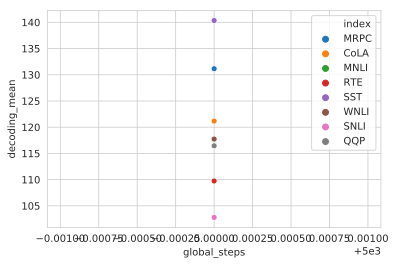

In [90]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="global_steps", hue="index")

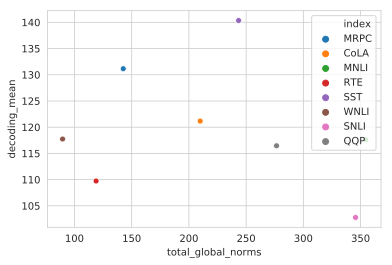

In [93]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="total_global_norms", hue="index")

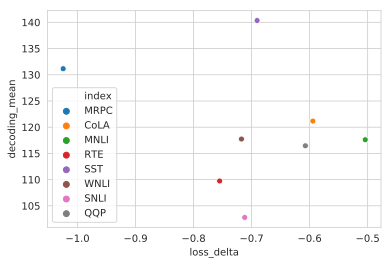

In [94]:
sns.scatterplot(data=df.reset_index(), y="decoding_mean", x="loss_delta", hue="index")

## Transfer checks

In [62]:
transfer_results = {}
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / "eval_transfer" / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]
        
pd.Series(transfer_results).reset_index()

,level_0,level_1,0
0,CoLA,MRPC,0.683824
1,CoLA,MNLI,0.348039
2,CoLA,RTE,0.541516
3,CoLA,SST,0.530963
4,CoLA,WNLI,0.563380
5,CoLA,SNLI,0.426539
6,CoLA,QQP,0.637052
7,MNLI,MRPC,0.683824
8,MNLI,CoLA,0.691275
